## Summary
This lesson introduced another statistical test: ANOVA.  ANOVAs are appropriate for comparing a numeric features when more than two groups are involved.  The assumption should be checked before running the test.  With ANOVA, the test itself determines whether or not there is ANY group statistically different than another.  If you get a significant result, you must then perform a second pairwise test to determine which groups are significantly different than another.

# Question: Do different diets result in different amounts of weight loss?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
url = 'https://docs.google.com/spreadsheets/d/1DW-2yHUm0YhH01r_kNp9ir5CaAlo9s48dhpIx-6J-TM/gviz/tq?tqx=out:csv&sheet=Diets'
df = pd.read_csv(url)
df.head()

,gender,Age,Height,pre.weight,Diet,weight6weeks,kg_lost
0,0,22,159,58,1,54.2,3.8
1,0,46,192,60,1,54.0,6.0
2,0,55,170,64,1,63.3,0.7
3,0,33,171,64,1,61.1,2.9
4,0,50,170,65,1,62.2,2.8


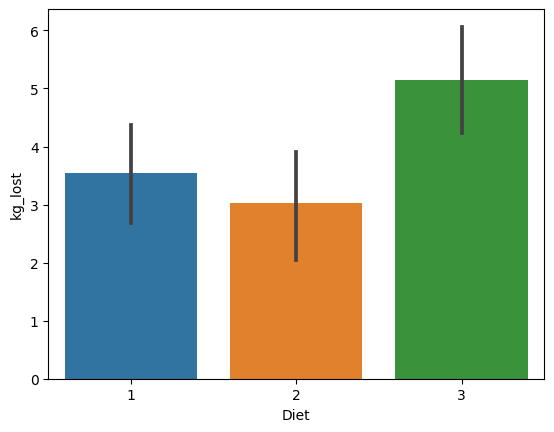

In [3]:
sns.barplot(data=df, x='Diet',y='kg_lost');

## Hypothesis

Null Hypothesis:  Different diets all have the same results. (the kg_lost is not significantly different between diets)

Alternative Hypothesis: Different diets have different results. (the kg_lost is significantly different between diets)

Using an alpha=.05

Note that our hypothesis do NOT specify which groups are different, just that there is or isn't a difference when taking all three into consideration.

## Separating Our Groups
Since we will need to analyze each group separately, it is in our best interest to use a dictionary with the group names (diet number in this case) as the keys and the column for kg_lost as the values.

In [4]:
## Create groups dictionary. There are only 3 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df['Diet'].unique():
    ## Get series for group and rename
    data = df.loc[df['Diet']==i,'kg_lost'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys([1, 2, 3])

## Testing Assumptions


Assumption of Normality

In [5]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
1,26.0,0.216027,3.064706
2,27.0,0.841993,0.343967
3,27.0,0.463144,1.539436


You can just analyze the output above, but when you are working with many groups, it can be helpful to use Pandas to keep you organized and ensure you don't miss anything.

In [6]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
1,26.0,0.216027,3.064706,False
2,27.0,0.841993,0.343967,False
3,27.0,0.463144,1.539436,False


We confirm that each group has a normal distribution.



## Testing Assumption of Equal Variance

Note: the * operator is a convenient way to unpack all of the values in an iterable (lists, dictionaries, etc) as separate variables.
By using *groups.values() below, we are saving ourselves from having to manually provide each group separately.

Example:

In [7]:
# not using * operator, entering each group manually
stats.levene(groups[1],
            groups[2],
            groups[3])

LeveneResult(statistic=0.30650755802082735, pvalue=0.7369067613743494)

OR

In [8]:
# with the * operator 
stats.levene(*groups.values())

LeveneResult(statistic=0.30650755802082735, pvalue=0.7369067613743494)

We met the assumption of equal variance.

# One-Way ANOVA Test
Now that we have checked the assumptions, we will perform the test.

In [9]:
# perform the correct hypothesis test
# note again the use of the * operator for convenience
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=5.679765022955312, pvalue=0.005001924377430895)

Oohh..a significant result! But...WHICH diets were different??

An ANOVA returns a single p-value to represent the differences between ALL groups. Now that we KNOW we have significant differences, we are allowed to perform pairwise comparisons between every group.
We will not use an ordinary t-test for this, instead, we will use a test that is specifically designed to adjust each pair's p-values so that we are less likely to make a Type I error.
## Tukey's Pairwise Multiple Comparisons Test
Tukey's test will compare every group against every other group and return a p-value for every possible combination of groups.

This is the only test that we will be using that is not available in scipy.
Instead, we will import pairwise_tukeyhsd from statsmodels

In [10]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values as kg_lost and the labels to the Diet
values = df['kg_lost']
labels = df['Diet']

In [11]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-0.5125,0.7204,-2.0964,1.0713,False
1,3,1.6097,0.0455,0.0259,3.1935,True
2,3,2.1222,0.0051,0.5534,3.691,True


You can see in the summary above that there are 2 significant results.  We see that there is a significant difference in weight loss between diet 1 and 3 and between diet 2 and 3.  There is no difference between 1 and 2.

Note, that this example only includes 3 groups to compare, but this summary would be much longer as the number of groups to compare increases since every pairwise combination is tested!

In conclusion, our test showed that there is a significant difference in the results of diet 3 compared to the other two diets.  The amount of kilograms lost was significantly higher for those who were on diet 3.